In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [2]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


In [6]:
# ドロップアウトテスト用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [7]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練フェーズでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [8]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

In [9]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [10]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [11]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [12]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [13]:
# Transformsの定義

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [14]:
# データ取得用関数 Dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

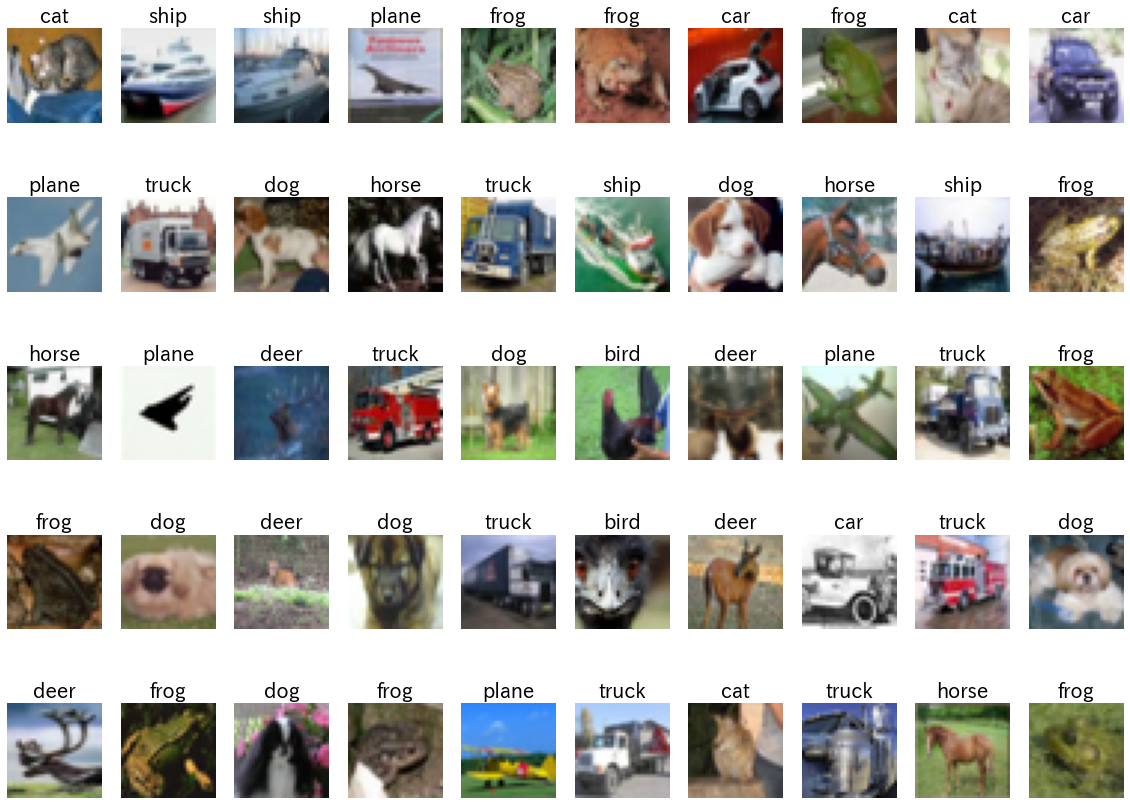

In [16]:
# 最初の50個の表示
show_images_labels(test_loader, classes, None, None)

In [17]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

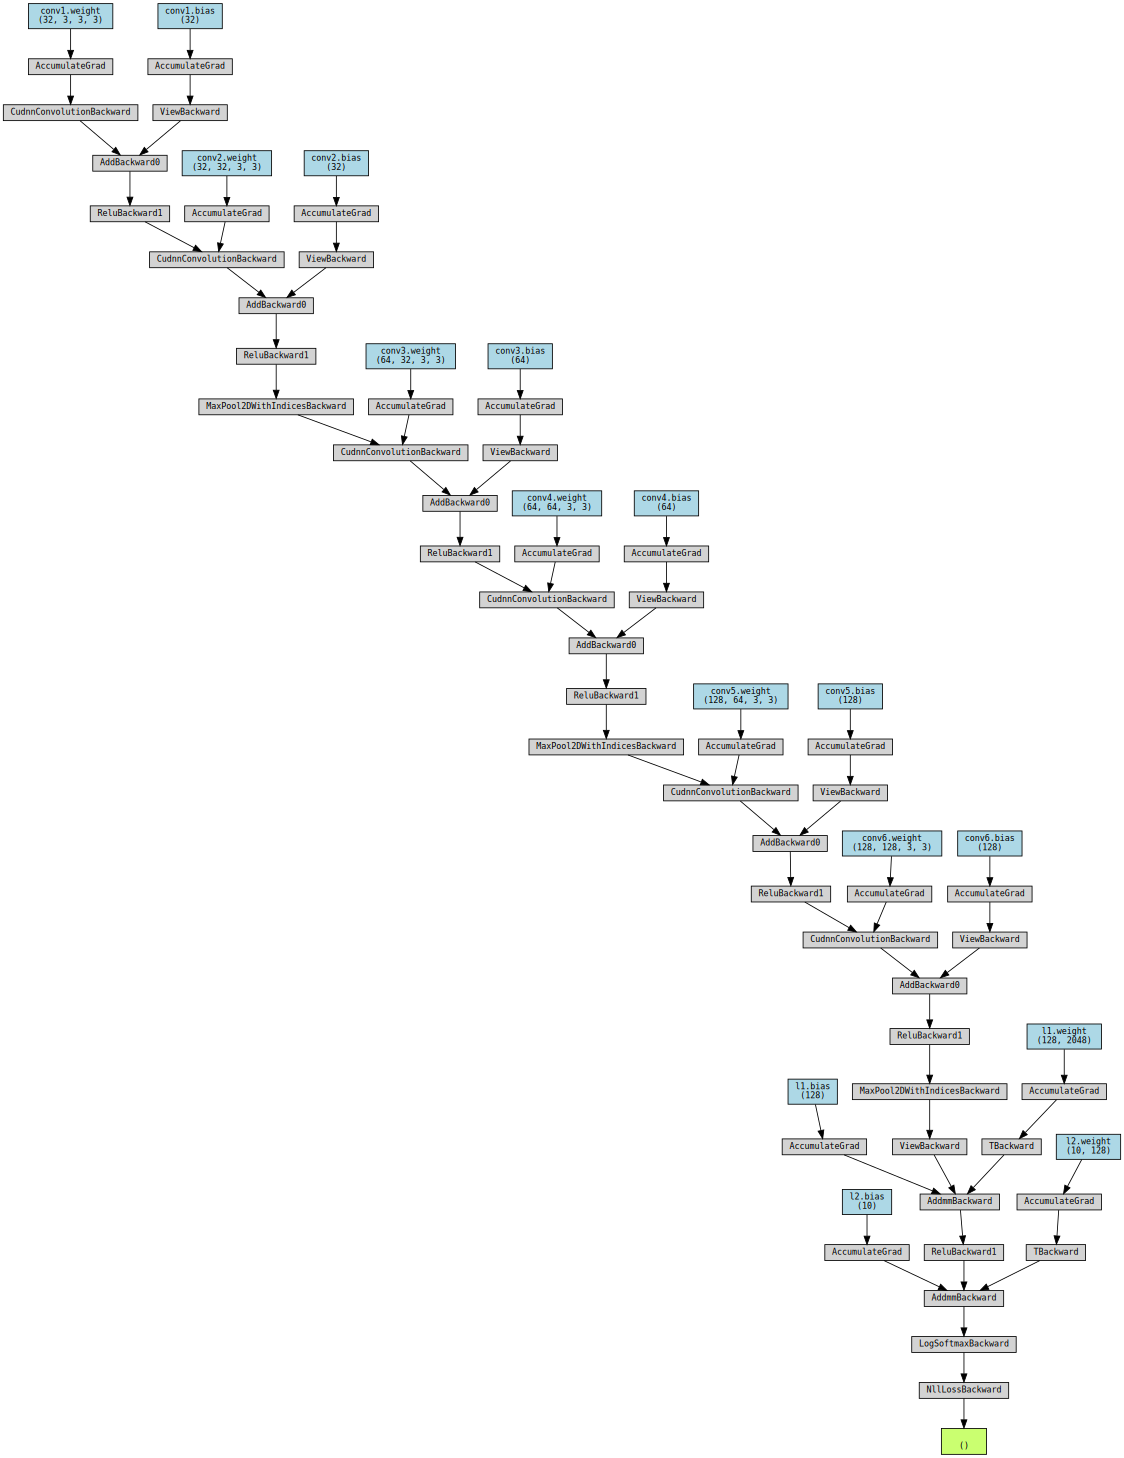

In [18]:
# 損失関数のグラフ表示
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [19]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [20]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  1%|          | 3/500 [00:00<00:17, 28.54it/s]

Epoch [1/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  1%|          | 3/500 [00:00<00:18, 27.23it/s]

Epoch [2/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000


  1%|          | 3/500 [00:00<00:19, 25.67it/s]

Epoch [3/50], loss: 0.02302 acc: 0.10000 val_loss: 0.02302, val_acc: 0.10000


  1%|          | 3/500 [00:00<00:18, 27.44it/s]

Epoch [4/50], loss: 0.02302 acc: 0.10844 val_loss: 0.02302, val_acc: 0.10170


  1%|          | 3/500 [00:00<00:18, 27.02it/s]

Epoch [5/50], loss: 0.02302 acc: 0.13020 val_loss: 0.02302, val_acc: 0.17500


  1%|          | 3/500 [00:00<00:18, 26.23it/s]

Epoch [6/50], loss: 0.02301 acc: 0.16738 val_loss: 0.02300, val_acc: 0.19110


  1%|          | 3/500 [00:00<00:17, 27.66it/s]

Epoch [7/50], loss: 0.02298 acc: 0.18536 val_loss: 0.02294, val_acc: 0.21840


  1%|          | 3/500 [00:00<00:18, 26.85it/s]

Epoch [8/50], loss: 0.02245 acc: 0.21890 val_loss: 0.02097, val_acc: 0.23870


  1%|          | 3/500 [00:00<00:18, 27.13it/s]

Epoch [9/50], loss: 0.02016 acc: 0.26100 val_loss: 0.01946, val_acc: 0.29340


  1%|          | 3/500 [00:00<00:17, 29.15it/s]

Epoch [10/50], loss: 0.01907 acc: 0.31256 val_loss: 0.01904, val_acc: 0.31080


  1%|          | 3/500 [00:00<00:18, 26.37it/s]

Epoch [11/50], loss: 0.01796 acc: 0.35158 val_loss: 0.01700, val_acc: 0.38730


  1%|          | 3/500 [00:00<00:16, 29.49it/s]

Epoch [12/50], loss: 0.01697 acc: 0.38300 val_loss: 0.01630, val_acc: 0.41260


  1%|          | 3/500 [00:00<00:17, 28.83it/s]

Epoch [13/50], loss: 0.01629 acc: 0.40644 val_loss: 0.01561, val_acc: 0.42970


  1%|          | 3/500 [00:00<00:17, 28.98it/s]

Epoch [14/50], loss: 0.01574 acc: 0.42142 val_loss: 0.01617, val_acc: 0.41580


  1%|          | 3/500 [00:00<00:16, 29.73it/s]

Epoch [15/50], loss: 0.01530 acc: 0.43664 val_loss: 0.01507, val_acc: 0.44290


  1%|          | 3/500 [00:00<00:17, 29.17it/s]

Epoch [16/50], loss: 0.01482 acc: 0.45896 val_loss: 0.01439, val_acc: 0.47270


  1%|          | 3/500 [00:00<00:17, 27.90it/s]

Epoch [17/50], loss: 0.01441 acc: 0.47458 val_loss: 0.01399, val_acc: 0.48670


  1%|          | 3/500 [00:00<00:17, 27.64it/s]

Epoch [18/50], loss: 0.01399 acc: 0.49300 val_loss: 0.01427, val_acc: 0.48330


  1%|          | 3/500 [00:00<00:17, 28.67it/s]

Epoch [19/50], loss: 0.01354 acc: 0.51338 val_loss: 0.01334, val_acc: 0.51700


  1%|          | 3/500 [00:00<00:17, 28.86it/s]

Epoch [20/50], loss: 0.01311 acc: 0.53288 val_loss: 0.01296, val_acc: 0.53110


  1%|          | 3/500 [00:00<00:17, 28.88it/s]

Epoch [21/50], loss: 0.01259 acc: 0.54928 val_loss: 0.01233, val_acc: 0.55670


  1%|          | 3/500 [00:00<00:16, 29.28it/s]

Epoch [22/50], loss: 0.01217 acc: 0.56698 val_loss: 0.01207, val_acc: 0.56580


  1%|          | 3/500 [00:00<00:17, 28.72it/s]

Epoch [23/50], loss: 0.01173 acc: 0.58348 val_loss: 0.01199, val_acc: 0.57600


  1%|          | 3/500 [00:00<00:16, 29.90it/s]

Epoch [24/50], loss: 0.01141 acc: 0.59590 val_loss: 0.01157, val_acc: 0.58560


  1%|          | 3/500 [00:00<00:17, 28.04it/s]

Epoch [25/50], loss: 0.01097 acc: 0.61164 val_loss: 0.01126, val_acc: 0.59810


  1%|          | 3/500 [00:00<00:18, 27.05it/s]

Epoch [26/50], loss: 0.01060 acc: 0.62470 val_loss: 0.01094, val_acc: 0.61440


  1%|          | 3/500 [00:00<00:18, 26.92it/s]

Epoch [27/50], loss: 0.01021 acc: 0.64232 val_loss: 0.01129, val_acc: 0.60230


  1%|          | 3/500 [00:00<00:18, 26.87it/s]

Epoch [28/50], loss: 0.00984 acc: 0.65384 val_loss: 0.01049, val_acc: 0.63350


  1%|          | 3/500 [00:00<00:17, 27.93it/s]

Epoch [29/50], loss: 0.00954 acc: 0.66666 val_loss: 0.00996, val_acc: 0.64900


  1%|          | 3/500 [00:00<00:16, 29.53it/s]

Epoch [30/50], loss: 0.00916 acc: 0.68132 val_loss: 0.00976, val_acc: 0.65750


  1%|          | 3/500 [00:00<00:18, 27.09it/s]

Epoch [31/50], loss: 0.00885 acc: 0.69040 val_loss: 0.00970, val_acc: 0.65970


  1%|          | 3/500 [00:00<00:18, 27.03it/s]

Epoch [32/50], loss: 0.00857 acc: 0.70028 val_loss: 0.00942, val_acc: 0.67270


  1%|          | 3/500 [00:00<00:18, 27.58it/s]

Epoch [33/50], loss: 0.00822 acc: 0.71344 val_loss: 0.00994, val_acc: 0.65700


  1%|          | 3/500 [00:00<00:18, 26.51it/s]

Epoch [34/50], loss: 0.00793 acc: 0.72410 val_loss: 0.00922, val_acc: 0.68330


  1%|          | 4/500 [00:00<00:16, 30.60it/s]

Epoch [35/50], loss: 0.00761 acc: 0.73698 val_loss: 0.00946, val_acc: 0.67460


  1%|          | 3/500 [00:00<00:18, 27.09it/s]

Epoch [36/50], loss: 0.00734 acc: 0.74514 val_loss: 0.00936, val_acc: 0.67690


  1%|          | 3/500 [00:00<00:17, 29.08it/s]

Epoch [37/50], loss: 0.00705 acc: 0.75320 val_loss: 0.00961, val_acc: 0.68200


  1%|          | 3/500 [00:00<00:16, 29.49it/s]

Epoch [38/50], loss: 0.00674 acc: 0.76574 val_loss: 0.00914, val_acc: 0.69420


  1%|          | 3/500 [00:00<00:17, 28.74it/s]

Epoch [39/50], loss: 0.00642 acc: 0.77780 val_loss: 0.00924, val_acc: 0.69610


  1%|          | 3/500 [00:00<00:16, 29.38it/s]

Epoch [40/50], loss: 0.00616 acc: 0.78578 val_loss: 0.00959, val_acc: 0.68630


  1%|          | 3/500 [00:00<00:16, 29.64it/s]

Epoch [41/50], loss: 0.00587 acc: 0.79526 val_loss: 0.00959, val_acc: 0.69060


  1%|          | 3/500 [00:00<00:16, 29.35it/s]

Epoch [42/50], loss: 0.00559 acc: 0.80392 val_loss: 0.00945, val_acc: 0.70160


  1%|          | 4/500 [00:00<00:16, 30.79it/s]

Epoch [43/50], loss: 0.00526 acc: 0.81608 val_loss: 0.00921, val_acc: 0.70370


  1%|          | 4/500 [00:00<00:16, 30.61it/s]

Epoch [44/50], loss: 0.00495 acc: 0.82682 val_loss: 0.00959, val_acc: 0.69970


  1%|          | 3/500 [00:00<00:16, 29.54it/s]

Epoch [45/50], loss: 0.00469 acc: 0.83656 val_loss: 0.01078, val_acc: 0.67150


  1%|          | 3/500 [00:00<00:18, 26.61it/s]

Epoch [46/50], loss: 0.00436 acc: 0.84648 val_loss: 0.00987, val_acc: 0.70210


  1%|          | 3/500 [00:00<00:18, 27.02it/s]

Epoch [47/50], loss: 0.00409 acc: 0.85664 val_loss: 0.01030, val_acc: 0.69600


  1%|          | 3/500 [00:00<00:17, 28.66it/s]

Epoch [48/50], loss: 0.00376 acc: 0.86834 val_loss: 0.01035, val_acc: 0.69780


  1%|          | 3/500 [00:00<00:17, 28.05it/s]

Epoch [49/50], loss: 0.00346 acc: 0.87892 val_loss: 0.01074, val_acc: 0.69900


100%|██████████| 500/500 [00:15<00:00, 32.30it/s]


Epoch [50/50], loss: 0.00314 acc: 0.89030 val_loss: 0.01113, val_acc: 0.68970


初期状態: 損失: 0.02303 精度: 0.10000
最終状態: 損失: 0.01113 精度: 0.68970


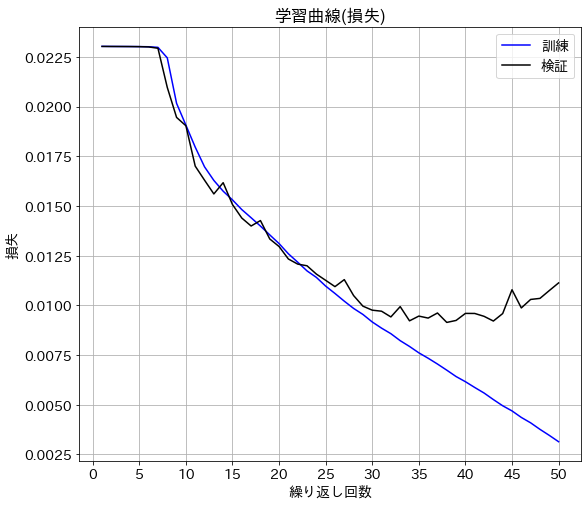

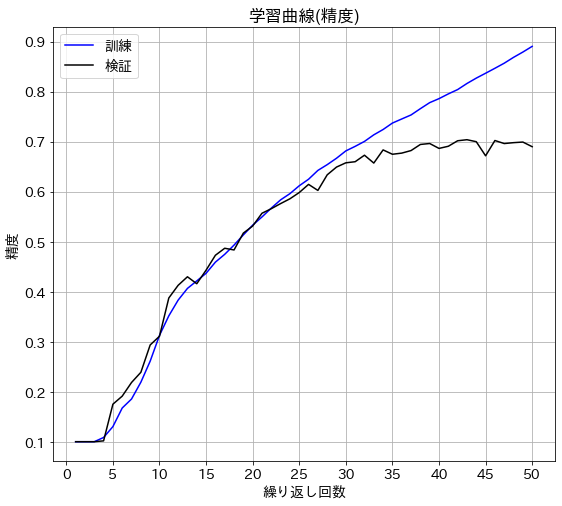

In [21]:
evaluate_history(history)

In [22]:
# 最適化関数
## momentum

In [23]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にmomentumを指定
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [24]:
# 学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  1%|          | 3/500 [00:00<00:17, 28.01it/s]

Epoch [1/20], loss: 0.02284 acc: 0.12272 val_loss: 0.02044, val_acc: 0.24570


  1%|          | 3/500 [00:00<00:17, 28.96it/s]

Epoch [2/20], loss: 0.01800 acc: 0.33648 val_loss: 0.01539, val_acc: 0.42610


  1%|          | 3/500 [00:00<00:17, 29.17it/s]

Epoch [3/20], loss: 0.01412 acc: 0.48198 val_loss: 0.01271, val_acc: 0.54130


  1%|          | 3/500 [00:00<00:18, 26.88it/s]

Epoch [4/20], loss: 0.01160 acc: 0.58488 val_loss: 0.01083, val_acc: 0.61420


  1%|          | 3/500 [00:00<00:17, 27.61it/s]

Epoch [5/20], loss: 0.00968 acc: 0.65632 val_loss: 0.00888, val_acc: 0.68600


  1%|          | 3/500 [00:00<00:18, 27.49it/s]

Epoch [6/20], loss: 0.00815 acc: 0.71364 val_loss: 0.00852, val_acc: 0.70480


  1%|          | 3/500 [00:00<00:18, 26.46it/s]

Epoch [7/20], loss: 0.00680 acc: 0.76246 val_loss: 0.00746, val_acc: 0.74060


  1%|          | 3/500 [00:00<00:17, 29.14it/s]

Epoch [8/20], loss: 0.00575 acc: 0.79906 val_loss: 0.00722, val_acc: 0.75440


  1%|          | 3/500 [00:00<00:17, 27.74it/s]

Epoch [9/20], loss: 0.00489 acc: 0.82988 val_loss: 0.00691, val_acc: 0.76720


  1%|          | 3/500 [00:00<00:17, 28.21it/s]

Epoch [10/20], loss: 0.00412 acc: 0.85516 val_loss: 0.00748, val_acc: 0.76590


  1%|          | 3/500 [00:00<00:20, 24.62it/s]

Epoch [11/20], loss: 0.00339 acc: 0.87956 val_loss: 0.00768, val_acc: 0.76600


  1%|          | 3/500 [00:00<00:17, 28.72it/s]

Epoch [12/20], loss: 0.00276 acc: 0.90122 val_loss: 0.00766, val_acc: 0.77660


  1%|          | 3/500 [00:00<00:17, 28.83it/s]

Epoch [13/20], loss: 0.00221 acc: 0.92136 val_loss: 0.00843, val_acc: 0.76860


  1%|          | 3/500 [00:00<00:17, 28.84it/s]

Epoch [14/20], loss: 0.00182 acc: 0.93592 val_loss: 0.00944, val_acc: 0.76220


  1%|          | 3/500 [00:00<00:18, 27.38it/s]

Epoch [15/20], loss: 0.00167 acc: 0.94112 val_loss: 0.01061, val_acc: 0.75940


  1%|          | 3/500 [00:00<00:17, 28.96it/s]

Epoch [16/20], loss: 0.00138 acc: 0.95122 val_loss: 0.01154, val_acc: 0.75220


  1%|          | 3/500 [00:00<00:18, 27.36it/s]

Epoch [17/20], loss: 0.00116 acc: 0.95962 val_loss: 0.01189, val_acc: 0.75430


  1%|          | 3/500 [00:00<00:17, 28.69it/s]

Epoch [18/20], loss: 0.00104 acc: 0.96338 val_loss: 0.01199, val_acc: 0.75970


  1%|          | 3/500 [00:00<00:17, 28.78it/s]

Epoch [19/20], loss: 0.00097 acc: 0.96530 val_loss: 0.01258, val_acc: 0.76380


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch [20/20], loss: 0.00082 acc: 0.97164 val_loss: 0.01299, val_acc: 0.77060


初期状態: 損失: 0.02044 精度: 0.24570
最終状態: 損失: 0.01299 精度: 0.77060


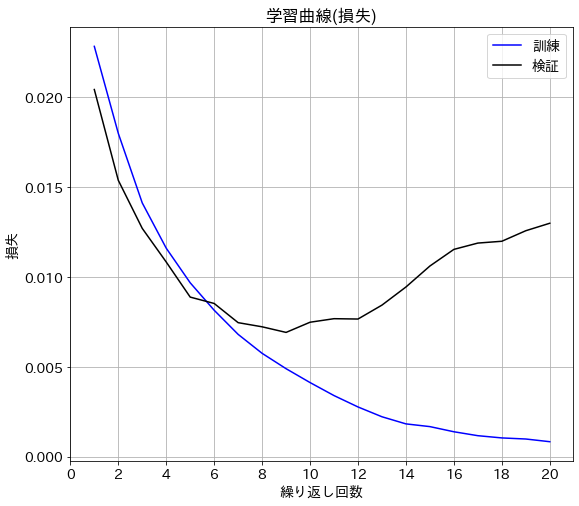

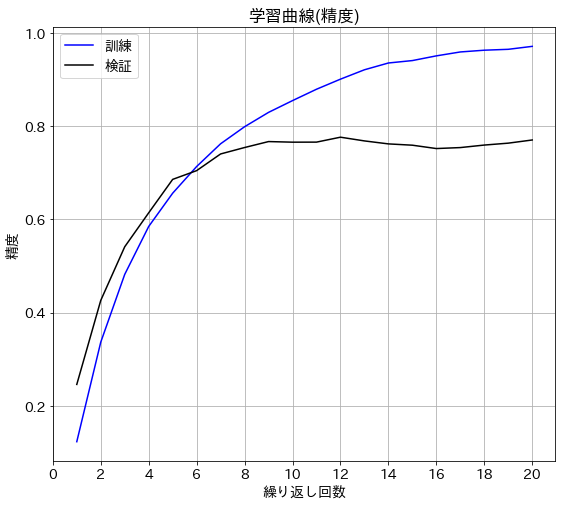

In [25]:
evaluate_history(history2)

In [26]:
# Adam

In [27]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [28]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [29]:
# 学習

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  1%|          | 3/500 [00:00<00:17, 28.93it/s]

Epoch [1/20], loss: 0.01586 acc: 0.41898 val_loss: 0.01243, val_acc: 0.54600


  1%|          | 3/500 [00:00<00:17, 28.84it/s]

Epoch [2/20], loss: 0.01093 acc: 0.60694 val_loss: 0.01036, val_acc: 0.63330


  1%|          | 3/500 [00:00<00:17, 28.00it/s]

Epoch [3/20], loss: 0.00876 acc: 0.68828 val_loss: 0.00875, val_acc: 0.70020


  1%|          | 3/500 [00:00<00:16, 29.41it/s]

Epoch [4/20], loss: 0.00726 acc: 0.74450 val_loss: 0.00763, val_acc: 0.73200


  1%|          | 3/500 [00:00<00:17, 28.12it/s]

Epoch [5/20], loss: 0.00611 acc: 0.78428 val_loss: 0.00737, val_acc: 0.74840


  1%|          | 3/500 [00:00<00:17, 28.64it/s]

Epoch [6/20], loss: 0.00518 acc: 0.81844 val_loss: 0.00697, val_acc: 0.76670


  1%|          | 3/500 [00:00<00:17, 29.01it/s]

Epoch [7/20], loss: 0.00437 acc: 0.84776 val_loss: 0.00712, val_acc: 0.76900


  1%|          | 3/500 [00:00<00:17, 28.80it/s]

Epoch [8/20], loss: 0.00365 acc: 0.87114 val_loss: 0.00723, val_acc: 0.77230


  1%|          | 3/500 [00:00<00:17, 28.70it/s]

Epoch [9/20], loss: 0.00302 acc: 0.89264 val_loss: 0.00784, val_acc: 0.76520


  1%|          | 3/500 [00:00<00:17, 28.90it/s]

Epoch [10/20], loss: 0.00243 acc: 0.91326 val_loss: 0.00859, val_acc: 0.76510


  1%|          | 3/500 [00:00<00:17, 28.71it/s]

Epoch [11/20], loss: 0.00199 acc: 0.92762 val_loss: 0.00935, val_acc: 0.76790


  1%|          | 3/500 [00:00<00:16, 29.32it/s]

Epoch [12/20], loss: 0.00174 acc: 0.93836 val_loss: 0.01001, val_acc: 0.75620


  1%|          | 3/500 [00:00<00:17, 28.35it/s]

Epoch [13/20], loss: 0.00143 acc: 0.94888 val_loss: 0.01061, val_acc: 0.76330


  1%|          | 3/500 [00:00<00:17, 28.87it/s]

Epoch [14/20], loss: 0.00126 acc: 0.95594 val_loss: 0.01140, val_acc: 0.75870


  1%|          | 3/500 [00:00<00:17, 29.06it/s]

Epoch [15/20], loss: 0.00117 acc: 0.95852 val_loss: 0.01243, val_acc: 0.75780


  1%|          | 3/500 [00:00<00:17, 28.56it/s]

Epoch [16/20], loss: 0.00101 acc: 0.96398 val_loss: 0.01297, val_acc: 0.76050


  1%|          | 3/500 [00:00<00:17, 28.96it/s]

Epoch [17/20], loss: 0.00105 acc: 0.96304 val_loss: 0.01337, val_acc: 0.76050


  1%|          | 3/500 [00:00<00:17, 28.66it/s]

Epoch [18/20], loss: 0.00087 acc: 0.97026 val_loss: 0.01388, val_acc: 0.75720


  1%|          | 3/500 [00:00<00:17, 29.17it/s]

Epoch [19/20], loss: 0.00087 acc: 0.97030 val_loss: 0.01486, val_acc: 0.75940


100%|██████████| 500/500 [00:15<00:00, 32.77it/s]


Epoch [20/20], loss: 0.00084 acc: 0.97108 val_loss: 0.01376, val_acc: 0.76270


初期状態: 損失: 0.01243 精度: 0.54600
最終状態: 損失: 0.01376 精度: 0.76270


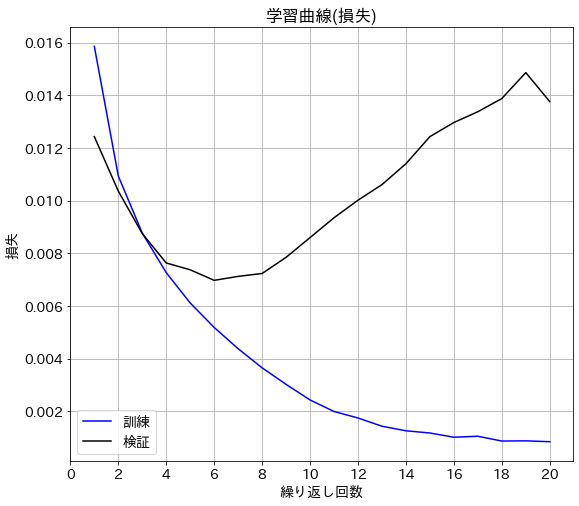

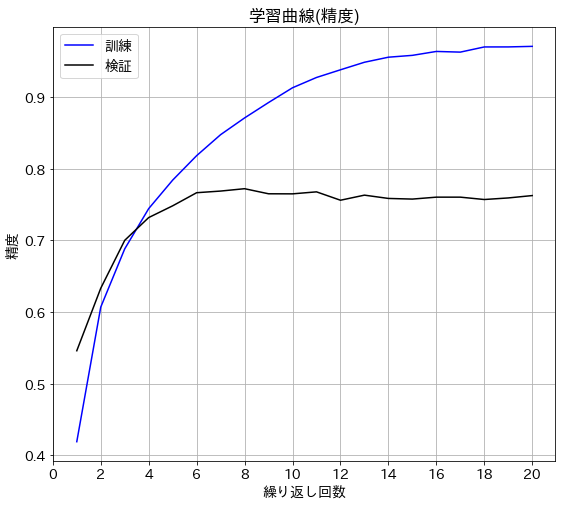

In [30]:
evaluate_history(history3)

In [31]:
# 結果比較

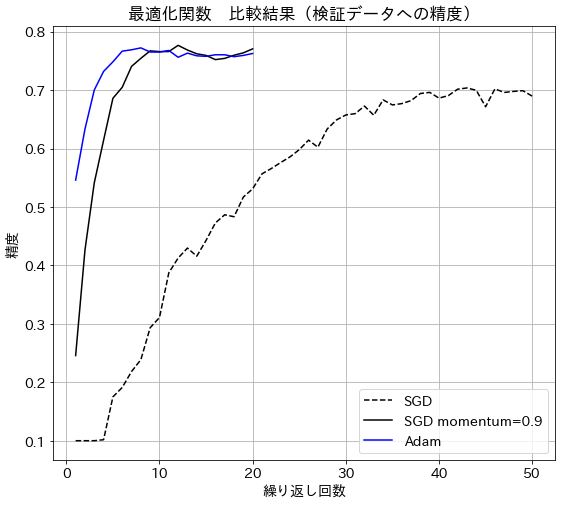

In [32]:
# 結果の比較(検証データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='k')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
plt.title('最適化関数　比較結果（検証データへの精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.legend()
plt.show()

In [33]:
# Dropout

In [34]:
# 予測クラスの定義

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

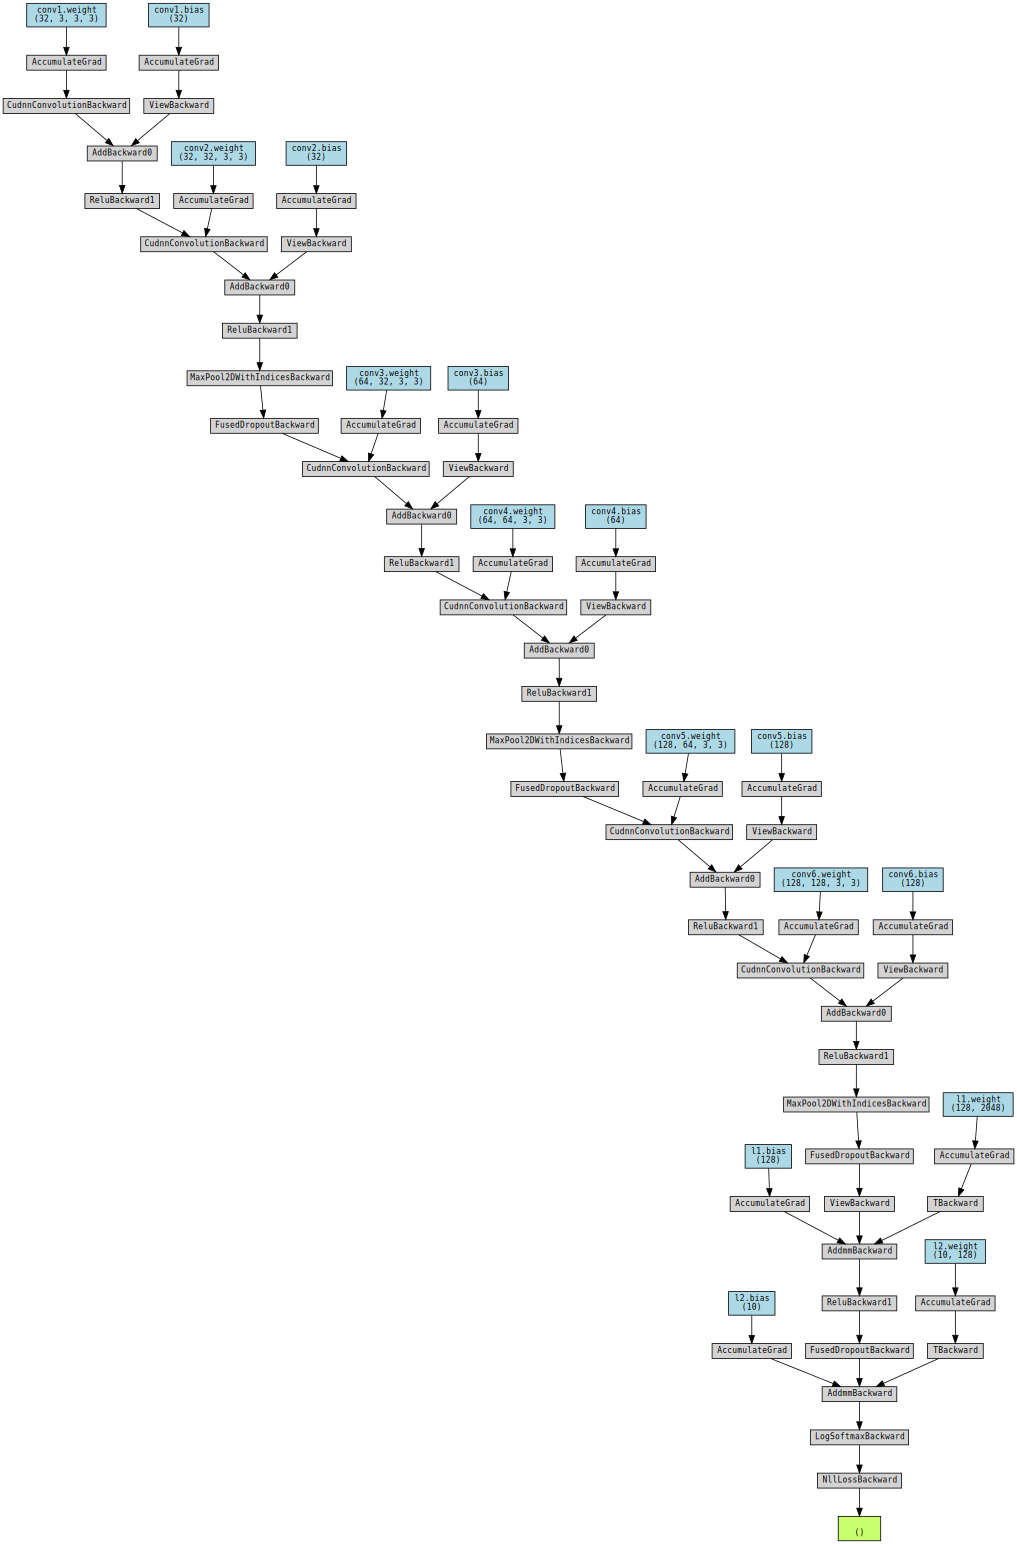

In [35]:
# 損失関数のグラフ表示
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [36]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [37]:

# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  1%|          | 3/500 [00:00<00:17, 28.17it/s]

Epoch [1/50], loss: 0.01737 acc: 0.35228 val_loss: 0.01350, val_acc: 0.50370


  1%|          | 3/500 [00:00<00:19, 25.95it/s]

Epoch [2/50], loss: 0.01328 acc: 0.51516 val_loss: 0.01131, val_acc: 0.58320


  1%|          | 3/500 [00:00<00:17, 28.22it/s]

Epoch [3/50], loss: 0.01158 acc: 0.58344 val_loss: 0.01097, val_acc: 0.59960


  1%|          | 3/500 [00:00<00:17, 27.69it/s]

Epoch [4/50], loss: 0.01034 acc: 0.63210 val_loss: 0.00953, val_acc: 0.66230


  1%|          | 3/500 [00:00<00:18, 27.28it/s]

Epoch [5/50], loss: 0.00952 acc: 0.66448 val_loss: 0.00822, val_acc: 0.70980


  1%|          | 3/500 [00:00<00:19, 25.84it/s]

Epoch [6/50], loss: 0.00881 acc: 0.69136 val_loss: 0.00806, val_acc: 0.71310


  1%|          | 3/500 [00:00<00:17, 28.11it/s]

Epoch [7/50], loss: 0.00819 acc: 0.71354 val_loss: 0.00740, val_acc: 0.73990


  1%|          | 3/500 [00:00<00:17, 28.59it/s]

Epoch [8/50], loss: 0.00777 acc: 0.72790 val_loss: 0.00745, val_acc: 0.73980


  1%|          | 3/500 [00:00<00:17, 28.08it/s]

Epoch [9/50], loss: 0.00742 acc: 0.73880 val_loss: 0.00670, val_acc: 0.76700


  1%|          | 3/500 [00:00<00:17, 28.71it/s]

Epoch [10/50], loss: 0.00706 acc: 0.75494 val_loss: 0.00684, val_acc: 0.76520


  1%|          | 3/500 [00:00<00:18, 26.90it/s]

Epoch [11/50], loss: 0.00686 acc: 0.76148 val_loss: 0.00673, val_acc: 0.76600


  1%|          | 3/500 [00:00<00:17, 28.54it/s]

Epoch [12/50], loss: 0.00655 acc: 0.77162 val_loss: 0.00643, val_acc: 0.77740


  1%|          | 3/500 [00:00<00:19, 25.89it/s]

Epoch [13/50], loss: 0.00633 acc: 0.78122 val_loss: 0.00632, val_acc: 0.78420


  1%|          | 3/500 [00:00<00:16, 29.32it/s]

Epoch [14/50], loss: 0.00617 acc: 0.78402 val_loss: 0.00616, val_acc: 0.79000


  1%|          | 3/500 [00:00<00:18, 26.32it/s]

Epoch [15/50], loss: 0.00601 acc: 0.79320 val_loss: 0.00616, val_acc: 0.79210


  1%|          | 3/500 [00:00<00:17, 28.21it/s]

Epoch [16/50], loss: 0.00586 acc: 0.79616 val_loss: 0.00584, val_acc: 0.79950


  1%|          | 3/500 [00:00<00:17, 28.78it/s]

Epoch [17/50], loss: 0.00577 acc: 0.79880 val_loss: 0.00565, val_acc: 0.80910


  1%|          | 3/500 [00:00<00:17, 27.85it/s]

Epoch [18/50], loss: 0.00560 acc: 0.80612 val_loss: 0.00606, val_acc: 0.79110


  1%|          | 3/500 [00:00<00:17, 28.97it/s]

Epoch [19/50], loss: 0.00548 acc: 0.81028 val_loss: 0.00570, val_acc: 0.81030


  1%|          | 3/500 [00:00<00:17, 29.21it/s]

Epoch [20/50], loss: 0.00539 acc: 0.81132 val_loss: 0.00597, val_acc: 0.80440


  1%|          | 3/500 [00:00<00:17, 29.17it/s]

Epoch [21/50], loss: 0.00532 acc: 0.81520 val_loss: 0.00563, val_acc: 0.81370


  1%|          | 3/500 [00:00<00:17, 28.93it/s]

Epoch [22/50], loss: 0.00524 acc: 0.81770 val_loss: 0.00543, val_acc: 0.81610


  1%|          | 3/500 [00:00<00:17, 27.80it/s]

Epoch [23/50], loss: 0.00517 acc: 0.82054 val_loss: 0.00573, val_acc: 0.81140


  1%|          | 3/500 [00:00<00:17, 28.73it/s]

Epoch [24/50], loss: 0.00512 acc: 0.82280 val_loss: 0.00575, val_acc: 0.80850


  1%|          | 3/500 [00:00<00:18, 26.84it/s]

Epoch [25/50], loss: 0.00499 acc: 0.82616 val_loss: 0.00554, val_acc: 0.82000


  1%|          | 3/500 [00:00<00:16, 29.26it/s]

Epoch [26/50], loss: 0.00494 acc: 0.82706 val_loss: 0.00560, val_acc: 0.81740


  1%|          | 3/500 [00:00<00:17, 29.08it/s]

Epoch [27/50], loss: 0.00484 acc: 0.83142 val_loss: 0.00558, val_acc: 0.81730


  1%|          | 3/500 [00:00<00:17, 28.92it/s]

Epoch [28/50], loss: 0.00487 acc: 0.83224 val_loss: 0.00555, val_acc: 0.81550


  1%|          | 3/500 [00:00<00:17, 28.78it/s]

Epoch [29/50], loss: 0.00474 acc: 0.83368 val_loss: 0.00565, val_acc: 0.81350


  1%|          | 3/500 [00:00<00:16, 29.29it/s]

Epoch [30/50], loss: 0.00469 acc: 0.83822 val_loss: 0.00556, val_acc: 0.82300


  1%|          | 3/500 [00:00<00:17, 28.60it/s]

Epoch [31/50], loss: 0.00467 acc: 0.83684 val_loss: 0.00544, val_acc: 0.82310


  1%|          | 3/500 [00:00<00:18, 26.61it/s]

Epoch [32/50], loss: 0.00470 acc: 0.83610 val_loss: 0.00547, val_acc: 0.81570


  1%|          | 3/500 [00:00<00:16, 29.37it/s]

Epoch [33/50], loss: 0.00461 acc: 0.83932 val_loss: 0.00549, val_acc: 0.81750


  1%|          | 3/500 [00:00<00:16, 29.25it/s]

Epoch [34/50], loss: 0.00458 acc: 0.84134 val_loss: 0.00543, val_acc: 0.82070


  1%|          | 3/500 [00:00<00:17, 28.45it/s]

Epoch [35/50], loss: 0.00450 acc: 0.84344 val_loss: 0.00551, val_acc: 0.82450


  1%|          | 3/500 [00:00<00:19, 25.94it/s]

Epoch [36/50], loss: 0.00446 acc: 0.84354 val_loss: 0.00564, val_acc: 0.81710


  1%|          | 3/500 [00:00<00:17, 29.16it/s]

Epoch [37/50], loss: 0.00439 acc: 0.84748 val_loss: 0.00561, val_acc: 0.82040


  1%|          | 3/500 [00:00<00:17, 29.16it/s]

Epoch [38/50], loss: 0.00442 acc: 0.84570 val_loss: 0.00545, val_acc: 0.82330


  1%|          | 3/500 [00:00<00:17, 28.29it/s]

Epoch [39/50], loss: 0.00435 acc: 0.84884 val_loss: 0.00561, val_acc: 0.82480


  1%|          | 3/500 [00:00<00:18, 27.41it/s]

Epoch [40/50], loss: 0.00430 acc: 0.84856 val_loss: 0.00567, val_acc: 0.82390


  1%|          | 3/500 [00:00<00:18, 27.34it/s]

Epoch [41/50], loss: 0.00427 acc: 0.84922 val_loss: 0.00561, val_acc: 0.82840


  1%|          | 3/500 [00:00<00:17, 29.13it/s]

Epoch [42/50], loss: 0.00419 acc: 0.85444 val_loss: 0.00542, val_acc: 0.82380


  1%|          | 3/500 [00:00<00:17, 28.83it/s]

Epoch [43/50], loss: 0.00424 acc: 0.84936 val_loss: 0.00550, val_acc: 0.82500


  1%|          | 3/500 [00:00<00:17, 28.93it/s]

Epoch [44/50], loss: 0.00418 acc: 0.85372 val_loss: 0.00540, val_acc: 0.83060


  1%|          | 3/500 [00:00<00:17, 28.93it/s]

Epoch [45/50], loss: 0.00416 acc: 0.85512 val_loss: 0.00524, val_acc: 0.83060


  1%|          | 3/500 [00:00<00:21, 23.12it/s]

Epoch [46/50], loss: 0.00415 acc: 0.85556 val_loss: 0.00536, val_acc: 0.82970


  1%|          | 3/500 [00:00<00:17, 28.64it/s]

Epoch [47/50], loss: 0.00404 acc: 0.85890 val_loss: 0.00546, val_acc: 0.82960


  1%|          | 3/500 [00:00<00:17, 28.89it/s]

Epoch [48/50], loss: 0.00402 acc: 0.86000 val_loss: 0.00545, val_acc: 0.83280


  1%|          | 3/500 [00:00<00:17, 28.10it/s]

Epoch [49/50], loss: 0.00408 acc: 0.85780 val_loss: 0.00556, val_acc: 0.82260


100%|██████████| 500/500 [00:15<00:00, 32.85it/s]


Epoch [50/50], loss: 0.00401 acc: 0.86054 val_loss: 0.00556, val_acc: 0.82830


初期状態: 損失: 0.01350 精度: 0.50370
最終状態: 損失: 0.00556 精度: 0.82830


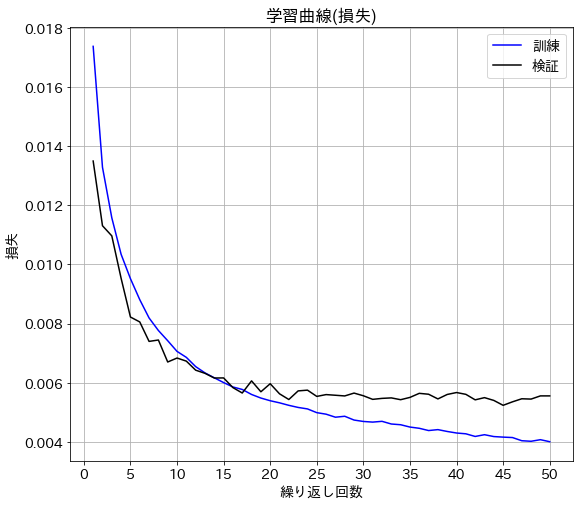

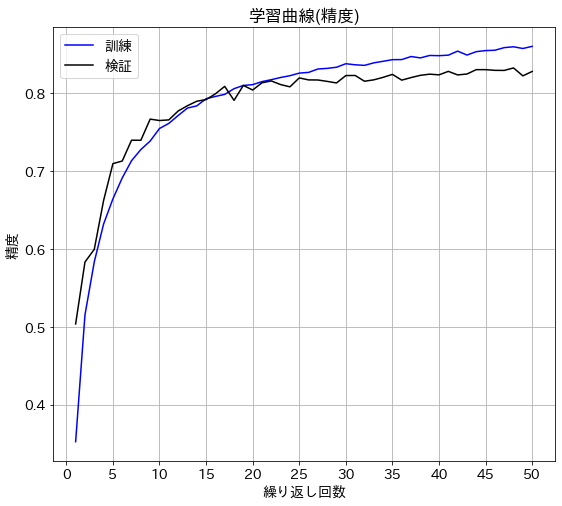

In [38]:
evaluate_history(history)

In [39]:
# Batch Normalization